In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import os
import pprint

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RNN
from keras.layers import SimpleRNN
from keras.layers import Bidirectional
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

#(Preprocessing and Normalization) , (Naive Baseline)

In [ ]:
dataset = pd.read_csv('Processed_S&P.csv')
'''
dataset = dataset[["Date", "Close", "Volume", \
             "mom", "mom1", "mom2", "mom3",\
            "ROC_5","ROC_10","ROC_15","ROC_20",\
            "EMA_10","EMA_20","EMA_50"]]
            '''

dataset = dataset[['Date','Close']]

In [ ]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.set_index(dataset['Date'])
dataset = dataset.sort_index()

In [ ]:
train = dataset['2009-12-31':'2016-05-06']
test  = dataset['2016-05-06':]
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)

Train Dataset: (1598, 2)
Test Dataset: (387, 2)


In [ ]:
train = train.dropna(axis = 0)
test  = test.dropna(axis = 0)

In [ ]:
def Moving_Average(dataset, period = 5, column = 'Close'):
  return dataset[column].rolling(window = period).mean()

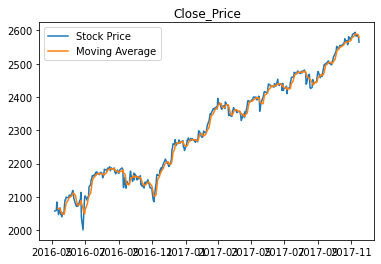

In [ ]:
plt.title("Close_Price")
plt.plot(test['Close'], label = 'Stock Price')
plt.plot(Moving_Average(test), label = 'Moving Average')
plt.legend()
plt.show()

In [ ]:
test['Moving Average'] = Moving_Average(test)

In [ ]:
#test

In [ ]:
test['Moving Average'] = Moving_Average(test)
result = test['Moving Average'].mean()
result

2305.7485937958186

In [ ]:
test['Moving Average'] = test['Moving Average'].fillna(result)

In [ ]:
stock_price = test.iloc[:, 1:2]
Naive_pred = test.iloc[:, 2:3]

In [ ]:
from sklearn.metrics import mean_squared_error

score_naive = mean_squared_error(Naive_pred, stock_price)
print("MSE with Naive_Baseline: ",score_naive)

MSE with Naive_Baseline:  751.9646590439697


# More Preprocessing

In [ ]:
training_set = train.iloc[:, 1:2].values
test_set = test.iloc[:, 1:2].values

In [ ]:
training_set.size

1598

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
X_train = []
y_train = []
for i in range(50, 1598):
    X_train.append(training_set_scaled[i-50:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(1548, 50, 1)

In [ ]:
test = test.drop(['Date'], axis=1)
train = train.drop(['Date'], axis=1)

In [ ]:
dataset_total = pd.concat((train['Close'], test['Close']), axis = 0)

In [ ]:
inputs = dataset_total[len(dataset_total) - len(test) - 50:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(50, 437):
    X_test.append(inputs[i-50:i, 0])
    y_test.append(inputs[i, 0])
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Simple Model

In [ ]:
regressor_A = Sequential()

In [ ]:
regressor_A.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor_A.add(Dropout(0.2))
regressor_A.add(LSTM(units = 50, return_sequences = True))
regressor_A.add(Dropout(0.2))
regressor_A.add(LSTM(units = 50, return_sequences = True))
regressor_A.add(Dropout(0.2))
regressor_A.add(LSTM(units = 50))
regressor_A.add(Dropout(0.2))
regressor_A.add(Dense(units = 1))
regressor_A.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics= 'mean_squared_error')

In [ ]:
history = regressor_A.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 100, batch_size = 32)

Epoch 1/100
49/49 [==============================] - 12s 122ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 2/100
49/49 [==============================] - 5s 94ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 3/100
49/49 [==============================] - 5s 93ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 4/100
49/49 [==============================] - 5s 93ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 5/100
49/49 [==============================] - 5s 92ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 6/100
49/49 [==============================] - 5s 93ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 7/100
49/49 [=======

In [ ]:
print(regressor_A.evaluate(X_test, y_test))

13/13 [==============================] - 0s 23ms/step - loss: 0.0098 - mean_squared_error: 0.0098
[0.009768689051270485, 0.009768689051270485]


In [ ]:
predicted_stock_price = regressor_A.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

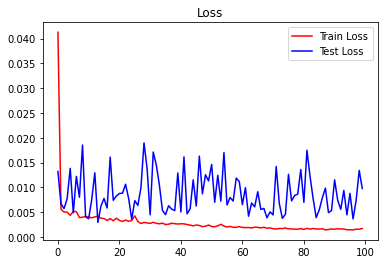

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'Train Loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'Test Loss')
plt.title('Loss')
plt.legend()
plt.show()

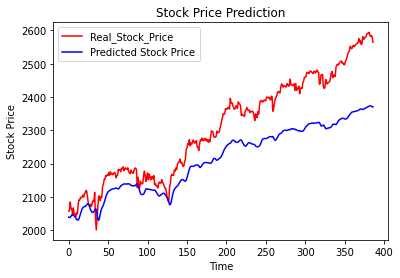

In [ ]:
plt.plot(test_set, color = 'red', label = 'Real_Stock_Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Advanced model



In [ ]:
dataset = dataset.dropna(axis = 0)

In [ ]:
dataset.shape

(1984, 2)

In [ ]:
Timestamp = 50
X = []
Y = []

In [ ]:
for i in range(0 , len(dataset) - Timestamp -1 , 1):
    first = dataset.iloc[i, 1]
    temp1 = []
    temp2 = []
    for j in range(Timestamp):
        temp1.append((dataset.iloc[i + j, 1] - first) / first)
    temp2.append((dataset.iloc[i +Timestamp, 1] - first) / first)
    X.append(np.array(temp1).reshape(50, 1))
    Y.append(np.array(temp2).reshape(1,1))

In [ ]:
X = np.array(X)
Y = np.array(Y)
X.shape

(1933, 50, 1)

In [ ]:
Y.shape

(1933, 1, 1)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2,shuffle=False)

In [ ]:
len_t = len(X_train)

In [ ]:
X_train.shape

(1546, 50, 1)

In [ ]:
X_test.shape

(387, 50, 1)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],1,50,1)
X_test = X_test.reshape(X_test.shape[0],1,50,1)

In [ ]:
regressor_B = Sequential()

In [ ]:
regressor_B.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu', input_shape=(None,50,1))))
regressor_B.add(TimeDistributed(MaxPooling1D(2)))
regressor_B.add(TimeDistributed(Conv1D(256, kernel_size=1, activation='relu')))
regressor_B.add(TimeDistributed(MaxPooling1D(2)))
regressor_B.add(TimeDistributed(Conv1D(512, kernel_size=1, activation='relu')))
regressor_B.add(TimeDistributed(MaxPooling1D(2)))
regressor_B.add(TimeDistributed(Flatten()))
regressor_B.add(Bidirectional(LSTM(200,return_sequences=True)))
regressor_B.add(Dropout(0.25))
regressor_B.add(Bidirectional(LSTM(200,return_sequences=False)))
regressor_B.add(Dropout(0.25))
regressor_B.add(Dense(1, activation='linear'))
regressor_B.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics= 'mean_squared_error')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

In [ ]:
#history = regressor_B.fit(X_train, Y_train, validation_data=(X_test,Y_test), shuffle=True, epochs=40,
                        #verbose=1, batch_size=64)

In [ ]:
history = regressor_B.fit(X_train, Y_train, validation_data=(X_test,Y_test), shuffle=True, epochs=100,
                        callbacks=[early_stop, reduce_LR, checkpoint, tb], verbose=1, batch_size=64)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 00001: val_loss improved from inf to 0.00018, saving model to weights.h5
25/25 [==============================] - 13s 197ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 1.8434e-04 - val_mean_squared_error: 1.8434e-04 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 5.5808e-04 - mean_squared_error: 5.5808e-04
Epoch 00002: val_loss did not improve from 0.00018
25/25 [==============================] - 3s 136ms/step - loss: 5.5808e-04 - mean_squared_error: 5.5808e-04 - val_loss: 8.4848e-04 - val_mean_squared_error: 8.4848e-04 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 5.0694e-04 - mean_squared_error: 5.0694e-04
Epoch 00003: val_loss improved from 0.00018 to 0.00013, saving model to weights.h5
25/25 [==============================] - 4s 144ms/step - loss: 5.0694e-04 - mean_squared_error: 5.0694e

In [ ]:
print(regressor_B.evaluate(X_test,Y_test))

13/13 [==============================] - 0s 18ms/step - loss: 1.1696e-04 - mean_squared_error: 1.1696e-04
[0.00011696232104441151, 0.00011696232104441151]


In [ ]:
predicted  = regressor_B.predict(X_test)
test_label = (Y_test[:,0])
predicted = np.array(predicted[:,0]).reshape(-1,1)

In [ ]:
for j in range(len_t , len_t + len(X_test)):
    temp =dataset.iloc[j,1] #
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp

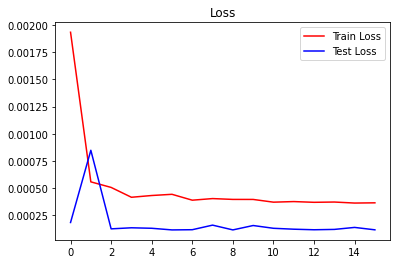

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'Train Loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'Test Loss')
plt.title('Loss')
plt.legend()
plt.show()

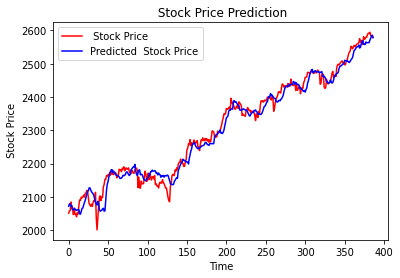

In [ ]:
plt.plot(test_label, color = 'Red', label = ' Stock Price')
plt.plot(predicted, color = 'Blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [ ]:
test['Moving Average'] = Moving_Average(test)

In [ ]:
test = test.reset_index()

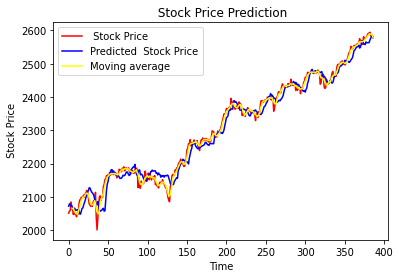

In [ ]:
plt.plot(test_label, color = 'Red', label = ' Stock Price')
plt.plot(predicted, color = 'Blue', label = 'Predicted  Stock Price')
plt.plot(test['Moving Average'], color = 'Yellow', label = 'Moving average')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()